# **Part 2. Inference Task**:
### Examine whether a sudden and sustained drop in oxygenation within the first 12 hours of hospitalization is predictive of hospital mortality (whether they eventually died later on in their hospitalization), and the magnitude and statistical significance of this association if there is one.


#### **To begin the data analysis process, Google Drive was first mounted to access the dataset files. Essential Python libraries such as pandas for data manipulation and numpy for numerical operations were imported. Then, the required datasets were loaded into DataFrames using pandas' read_csv function to prepare for exploratory data analysis and machine learning tasks.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def load_data():
    """Load data from CSV files and filter to smallest 1000 unique subject_ids with verification."""

    file_paths = {
        "Patient Feature Matrix": "/content/drive/MyDrive/technicaltaskdata/patient_feature_matrix.csv",
        "Feature Descriptions": "/content/drive/MyDrive/technicaltaskdata/feature_descriptions.csv",
        "Cohort": "/content/drive/MyDrive/technicaltaskdata/cohort.csv"
    }

    patient_features = pd.read_csv(file_paths["Patient Feature Matrix"])
    feature_descriptions = pd.read_csv(file_paths["Feature Descriptions"])
    cohort = pd.read_csv(file_paths["Cohort"])


    return patient_features, feature_descriptions, cohort

patient_features, feature_descriptions, cohort = load_data()



In [4]:
#Observe features in each dataframe
data = {
    "Patient Features": patient_features,
    "Feature Descriptions": feature_descriptions,
    "Cohort": cohort
}
for name, df in data.items():
    print(f"\n{name}_data:")
    print(df.head(10))



Patient Features_data:
   subject_id death_in_stay  oxy_drop gender   age_in_days  \
0          91          died    stable      F  29809.000000   
1         106          died  oxy_drop      M  10358.333333   
2         111      survived  oxy_drop      F  24388.979167   
3         117          died  oxy_drop      F  18224.075000   
4           3      survived  oxy_drop      M  27951.375000   
5          31          died  oxy_drop      M  26396.000000   
6          36      survived  oxy_drop      M  25474.541667   
7          38      survived  oxy_drop      M  27738.986111   
8         357      survived  oxy_drop      M  22905.916667   
9         360      survived    stable      F  27900.291667   

   icd9_ ADENOID CYSTIC CARCINOMA/SDA  icd9_ INTRACTABLE EPILEPSY/SDA  \
0                                   0                               0   
1                                   0                               0   
2                                   0                               0   
3

In [5]:
# Check the values in the 'death_in_stay' and 'oxy_drop' column in cohort dataset to understand possible values
print("Unique values in 'death_in_stay' column:")
print(cohort['death_in_stay'].unique())
print("Unique values in 'oxy_drop' column:")
print(cohort['oxy_drop'].unique())

Unique values in 'death_in_stay' column:
['died' 'survived']
Unique values in 'oxy_drop' column:
['stable' 'oxy_drop']


#### **A copy of the cohort dataset file was created, allowing for downstream changes:**
* The columns `death_in_stay` and `oxy_drop` were converted into binary values (1 = died, oxy_drop, 0 = survived, stable).
* The `index_time` column was converted to datetime.
* A new column was created indicating subject who had a drop in O2 within 12 hours.

In [6]:
#Create copy
cohort_copy = cohort.copy()

In [7]:
#Reset copy if needed
cohort_copy = cohort_copy.reset_index(drop=True)

In [8]:
# Convert to binary
cohort_copy['death_in_stay'] = cohort_copy['death_in_stay'].apply(lambda x: 1 if x == 'died' else 0)
cohort_copy['oxy_drop'] = cohort_copy['oxy_drop'].apply(lambda x: 1 if x == 'oxy_drop' else 0)

In [9]:
# Convert datetime
cohort_copy['index_time'] = pd.to_datetime(cohort_copy['index_time'])
cohort_copy['exposure_time'] = pd.to_datetime(cohort_copy['exposure_time'], errors='coerce')

# Calculate difference between exposure time and index time
cohort_copy['oxy_drop_time'] = (cohort_copy['exposure_time'] - cohort_copy['index_time']).dt.total_seconds()/3600

In [10]:
# Create column indicating subject who had a drop in O2 within 12 hours
cohort_copy['early_drop'] = 0
cohort_copy.loc[(cohort_copy['oxy_drop'] == 1) & (cohort_copy['oxy_drop_time'] <= 12), 'early_drop'] = 1

In [11]:
cohort_copy.head(10)

,subject_id,icustay_id,death_in_stay,deathtime,censor_time,index_time,exposure_time,oxy_drop,oxy_drop_time,early_drop
0,91,256972,1,2177-05-10 15:16:00,2177-05-10 15:16:00,2177-05-08 00:00:00,NaT,0,NaN,0
1,106,252051,1,2192-08-15 21:15:00,2192-08-15 21:15:00,2192-08-10 08:00:00,2192-08-14 16:33:00,1,104.550000,0
2,111,254245,0,NaN,2142-05-05 11:45:00,2142-04-24 23:30:00,2142-04-25 18:32:00,1,19.033333,0
3,117,217966,1,2133-12-01 17:00:00,2133-12-01 17:00:00,2133-11-20 01:48:00,2133-11-20 04:05:00,1,2.283333,1
4,3,211552,0,NaN,2101-10-31 13:58:00,2101-10-21 09:00:00,2101-10-21 09:46:00,1,0.766667,1
5,31,254478,1,2108-08-30 15:00:00,2108-08-30 15:00:00,2108-08-24 00:00:00,2108-08-26 04:01:00,1,52.016667,0
6,36,211200,0,NaN,2131-05-25 13:30:00,2131-05-17 13:00:00,2131-05-17 13:23:00,1,0.383333,1
7,38,248910,0,NaN,2166-09-04 11:30:00,2166-08-11 23:40:00,2166-08-18 10:09:00,1,154.483333,0
8,357,228283,0,NaN,2198-01-03 14:00:00,2197-12-06 22:00:00,2197-12-07 19:22:00,1,21.366667,0
9,360,260104,0,NaN,2176-07-02 14:28:00,2176-06-26 07:00:00,NaT,0,NaN,0


In [12]:
# Verify
print("Patients meeting early drop criteria:")
print(cohort_copy['early_drop'].sum())

print("\nTime to drop (hours) summary:")
print(cohort_copy['early_drop'].describe())

Patients meeting early drop criteria:
482

Time to drop (hours) summary:
count    3455.000000
mean        0.139508
std         0.346526
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: early_drop, dtype: float64


#### **Two key analyses were performed:**


##### **A chi-square test and heatmap were used to compare hospital mortality rates between patients with and without early oxygen drops for simple visualization. However, this method does not account for confounders.**


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

In [14]:
# Create the table
count = pd.crosstab(cohort_copy['early_drop'], cohort_copy['death_in_stay'])
percent = pd.crosstab(cohort_copy['early_drop'], cohort_copy['death_in_stay'], normalize='index')

In [15]:
# Perform chi-square test (will return 4 values)
chisq_statistic, p_value, degrees_freedom, expected_counts = chi2_contingency(count)

In [16]:
# Create combined display matrix
display_df = pd.DataFrame({
    'Group': ['No Early Oxygen Drop', 'Early Oxgen Drop'],
    'Died (n)': count[0].values,
    'Survived (n)': count[1].values,
    'Hospital Mortality (%)': [f"{x:.1%}" for x in percent[0].values],
    'Survival (%)': [f"{x:.1%}" for x in percent[1].values]
})


In [17]:
# Edit style of table
def style_table(df):
    return (df.style
            .set_properties(**{'text-align': 'center'})
            .set_table_styles([{
                'selector': 'th',
                'props': [('background-color', '#40466e'),
                         ('color', 'white'),
                         ('font-weight', 'bold')]
            }])
            .hide(axis='index'))

χ² test p-value: 0.1398

Hospital Mortality by Early Oxygen Drop Status


Group,Died (n),Survived (n),Hospital Mortality (%),Survival (%)
No Early Oxygen Drop,2443,530,82.2%,17.8%
Early Oxgen Drop,382,100,79.3%,20.7%


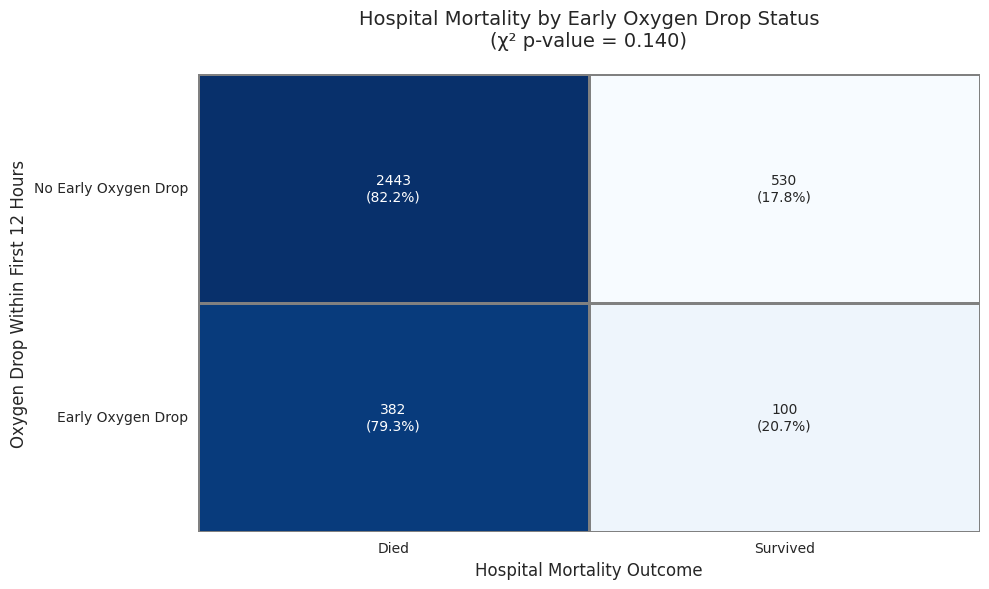

In [18]:
# Display results
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

annot = np.empty_like(percent.values, dtype=object)
for i in range(percent.shape[0]):
    for j in range(percent.shape[1]):
        annot[i,j] = f"{count.values[i,j]}\n({percent.values[i,j]:.1%})"

ax = sns.heatmap(percent,
                 annot=annot,
                 fmt='',
                 cmap='Blues',
                 cbar=False,
                 linewidths=1,
                 linecolor='gray')

plt.title(f'Hospital Mortality by Early Oxygen Drop Status\n(χ² p-value = {p_value:.3f})', pad=20, fontsize=14)
ax.set_xlabel('Hospital Mortality Outcome', fontsize=12)
ax.set_ylabel('Oxygen Drop Within First 12 Hours', fontsize=12)
ax.set_xticklabels(['Died', 'Survived'])
ax.set_yticklabels(['No Early Oxygen Drop', 'Early Oxygen Drop'], rotation=0)

plt.tight_layout()

# Display results
print(f"χ² test p-value: {p_value:.4f}\n")
print("Hospital Mortality by Early Oxygen Drop Status")
display(style_table(display_df))
plt.show()

##### **To improve analysis, a logistic regression was used. It quantifies the effect size, not just a *p*-value. It can adjust for confounders (chi-square cannot). It handles continuous predictors (chi-square requires categorical variables). Forest plot and predicted probablity curves used to visualize relationships.**

In [19]:
#Logistic Regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.logit('death_in_stay ~ early_drop', data=cohort_copy).fit()
model.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.474596
         Iterations 5


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-1.528105,0.047918,-31.890067,3.666469e-223,-1.622022,-1.434188
early_drop,0.187855,0.122123,1.538246,1.239884e-01,-0.051501,0.427211


Optimization terminated successfully.
         Current function value: 0.474596
         Iterations 5


/tmp/ipython-input-20-1962180871.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


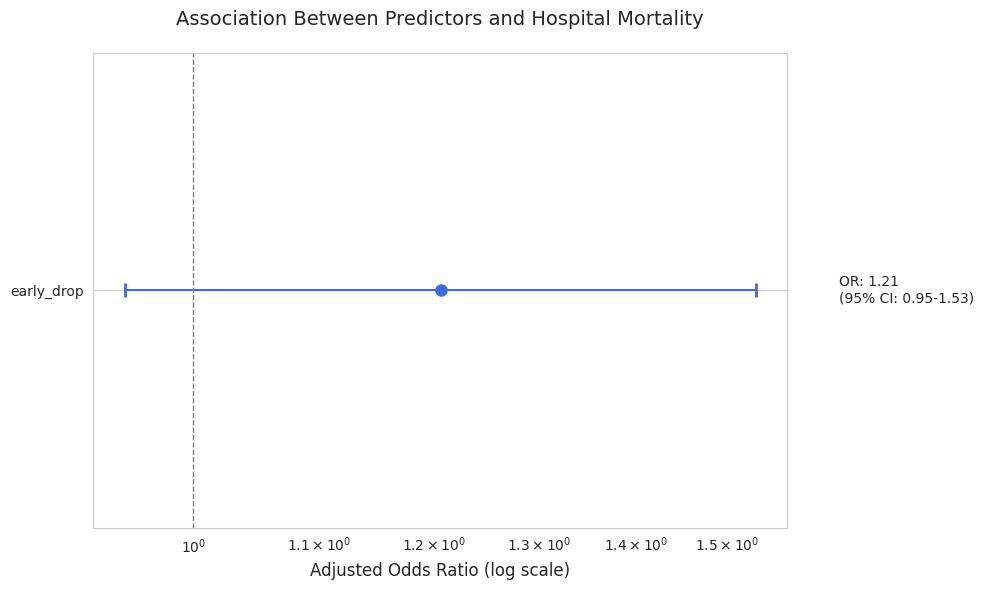

In [20]:
#Forest Plot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.formula.api import logit


model = logit('death_in_stay ~ early_drop', data=cohort_copy).fit()

results_df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]

results_df['OR'] = np.exp(results_df['coef'])
results_df['Lower_CI'] = np.exp(results_df['[0.025'])
results_df['Upper_CI'] = np.exp(results_df['0.975]'])


plot_data = results_df.loc[['early_drop']].reset_index()

# Create forest plot
plt.figure(figsize=(10, 6))
plt.errorbar(x=plot_data['OR'],
             y=plot_data.index,
             xerr=[plot_data['OR'] - plot_data['Lower_CI'],
                   plot_data['Upper_CI'] - plot_data['OR']],
             fmt='o',
             color='royalblue',
             markersize=8,
             capsize=5,
             capthick=2)
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)
plt.yticks(plot_data.index, plot_data['index'])
plt.xlabel('Adjusted Odds Ratio (log scale)', fontsize=12)
plt.title('Association Between Predictors and Hospital Mortality', fontsize=14, pad=20)
plt.xscale('log')
for i, row in plot_data.iterrows():
    plt.text(row['Upper_CI'] + 0.1, i,
             f"OR: {row['OR']:.2f}\n(95% CI: {row['Lower_CI']:.2f}-{row['Upper_CI']:.2f})",
             va='center', fontsize=10)

plt.grid(axis='x', alpha=0.2)
plt.tight_layout()
plt.show()

/tmp/ipython-input-21-3234051603.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x='early_drop', y='prob', data=pred_data,


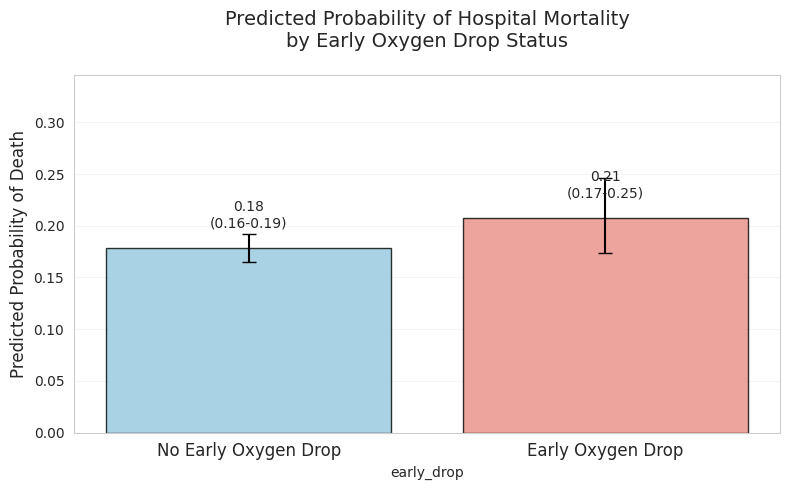

In [21]:
# Predicted Probability Curve
pred_data = pd.DataFrame({'early_drop': [0, 1],})
pred_data['prob'] = model.predict(pred_data)
pred_ci = model.get_prediction(pred_data).conf_int(alpha=0.05)
pred_data['lower'] = pred_ci[:, 0]
pred_data['upper'] = pred_ci[:, 1]

# Plot cruve
plt.figure(figsize=(8, 5))
bar = sns.barplot(x='early_drop', y='prob', data=pred_data,
                 palette=['skyblue', 'salmon'],
                 edgecolor='black',
                 alpha=0.8)
plt.errorbar(x=pred_data.index,
             y=pred_data['prob'],
             yerr=[pred_data['prob'] - pred_data['lower'],
                   pred_data['upper'] - pred_data['prob']],
             fmt='none',
             color='black',
             capsize=5)
plt.xticks([0, 1], ['No Early Oxygen Drop', 'Early Oxygen Drop'], fontsize=12)
plt.ylabel('Predicted Probability of Death', fontsize=12)
plt.title('Predicted Probability of Hospital Mortality\nby Early Oxygen Drop Status', fontsize=14, pad=20)
plt.ylim(0, min(1, pred_data['upper'].max() + 0.1))
for i, row in pred_data.iterrows():
    plt.text(i, row['prob'] + 0.02,
             f"{row['prob']:.2f}\n({row['lower']:.2f}-{row['upper']:.2f})",
             ha='center', fontsize=10)
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

#### **Explanation of methods used and results**



**1. Data Loading and Initial Inspection:**
- Since Google Colab was used, Google Drive was mounted to access the datasets. Necessary libraries for data manipulation (pandas), numerical operations (numpy), and plotting (matplotlib) were imported. A function load_data was defined to read three CSV files: patient_feature_matrix.csv, `eature_descriptions.csv, and cohort.csv. This function loaded the data into pandas DataFrames.
- The head of each DataFrame was displayed to get a sense of the data and the columns available. The unique values in the death_in_stay and oxy_drop columns were checked to understand the possible categories for these variables.
**Reasoning:** Loading and analyzing the data is the initial stage. It makes it feasible to understand the data's columns, format, and potential issues before analysis or modelling.

**2. Data Preparation and Preprocessing:**
- A copy of the cohort DataFrame was created.
- The death_in_stay and oxy_drop columns in the copied DataFrame were converted into binary values (1 for 'died'/'oxy_drop', 0 for 'survived'/'stable').
- The index_time and exposure_time columns were converted to datetime objects.
- The time difference between exposure_time and index_time was calculated in hours and stored in a new column oxy_drop_time.
- A new binary column early_drop was created to indicate subjects who had an oxygen drop within the first 12 hours of hospitalization.
- The number of patients meeting the early_drop criteria and a summary of the early_drop time were printed for verification.
**Reasoning:** By managing datetime information, converting categorical variables to a numerical format, and developing a crucial characteristic (early_drop) pertinent to the study issue, these procedures were carried out to get the data ready for the subsequent analysis.

**3. Exploratory Analysis:**
- A contingency table was created to show the counts and percentages of hospital mortality outcomes for patients with and without an early oxygen drop.
- A chi-square test of independence was performed to assess the statistical association between early oxygen drop and hospital mortality.
- A heatmap was generated to visualize the percentages from the contingency table.
- The chi-square test p-value and the styled contingency table were displayed.
**Reasoning:** Through straightforward cross-tabulation and a statistical test that does not presuppose a particular distribution, these exploratory procedures offer preliminary insights into the association between early oxygen decline and hospital mortality.  The proportions are shown visually in the heatmap.

**4. Logistic Regression Analysis:**
- A logistic regression model was fitted using death_in_stay as the outcome and early_drop as the predictor.
- The summary of the logistic regression model was displayed, providing coefficients, standard errors, p-values, and confidence intervals.
**Reasoning:** The relationship between early oxygen drop and hospital mortality was measured using logistic regression, which also produced an odds ratio—a gauge of impact size.  Because it may take into consideration potential confounders (albeit none were present in this model) and is appropriate for a binary outcome, this approach is more reliable than the chi-square test.

**5. Visualization of Results:**
- Data was prepared to create a forest plot and a predicted probability plot based on the logistic regression results.
- The forest plot adjusts odds ratio for sudden drop in oxygenation and its 95% confidence interval from the logistic regression model. This plot provides a clear visual representation of the effect size and its precision.
-The predicted probability bar plot shows predicted probability of hospital mortality for patients with and without a sudden drop in oxygenatin, along with their 95% confidence intervals. This plot helps to visualize the absolute difference in predicted mortality risk between the two groups.
**Reasoning:** For the analysis's findings to be communicated successfully, visualizations are essential.  The projected probability plot displays the absolute risk difference between the two groups, whereas the forest plot clearly displays the association's effect size and precision.

**6. Interpretation of Results:**
- The results from the chi-square test, logistic regression, and the generated plots were interpreted to draw conclusions about the association between early oxygen drop and hospital mortality.
- The p-value of 0.1398 from the chi-square test indicates no statistically significant association between sudden drop in oxygenation within the first 12 hours and hospital mortality. The odds ratio close to 1 and a p-value of 0.124 for the early_drop variable from the logistic regression results also indicated no statistically significant association at the 0.05 significance level. The confidence interval for the odds ratio crossed 1 wasvisually confirmed by the forest plot, further supporting the lack of a statistically significant association. A small, non-statistically significant difference in predicted mortality probabilities between the two groups was also shown in the predicted probability plot. In conclusion, the results of these analyses did not indicate a statistically significant association between a sudden and sustained drop in oxygenation within the first 12 hours of hospitalization and hospital mortality in this dataset.